# Hyperparameter Tuning with SVMs


# The Tools

In [290]:
# import appropriate analysis and ml tools

import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import grid_search, svm
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# The Data
Import breast cancer data from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

In [291]:
#import the raw data
raw_data = pd.read_csv("breast-cancer-wisconsin.data", 
                       names = ["id",  "Clump Thickness", "Uniformity of Cell Size","Uniformity of Cell Shape", 
                                  "Marginal Adhesion", "Single Epithelial Cell Size","Bare Nuclei", "Bland Chromatin",
                                  "Normal Nucleoli", "Mitoses", "Class"])
print(raw_data.shape)
raw_data.head()

(683, 11)


,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2



Drop ID column and Class (Diagnosis) column as we do not want to use them as features. We will then normalize the data to fit a standard normal distribution. We will also separate the features and the labels of the data and reassign the class labels to 1's (malignant) and 0's (benign)

In [292]:
# drop ID and Class columns
raw_data2 = raw_data.drop(['id','Class'], axis=1)

# normalize the data to have a mean of 0 and std deviation of 1 (standard normal distribution)
# normalize by subtracting raw scores from mean and dividing by std deviation (z-score)
norm_data = (raw_data2 - np.mean(raw_data2)) / np.std(raw_data2)
norm_data.head()

# map class variable to 1's (malignant) and 0's (benign)
norm_data['Class'] = raw_data['Class'].map({4:1, 2:0})
norm_data.head()


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0.197905,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.181827,-0.612927,-0.3484,0
1,0.197905,0.277252,0.262783,0.758032,1.695166,1.772867,-0.181827,-0.285105,-0.3484,0
2,-0.511643,-0.702212,-0.741774,-0.639366,-0.555608,-0.424217,-0.181827,-0.612927,-0.3484,0
3,0.552679,1.583204,1.602192,-0.639366,-0.105454,0.125054,-0.181827,1.354008,-0.3484,0
4,-0.156869,-0.702212,-0.741774,0.059333,-0.555608,-0.698853,-0.181827,-0.612927,-0.3484,0


Separate normalized data into features and labels.

In [293]:
# divide normalized data into features and labels
features = norm_data.drop('Class', axis=1)
labels = norm_data['Class']
print(labels.head())
features.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,0.197905,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.181827,-0.612927,-0.3484
1,0.197905,0.277252,0.262783,0.758032,1.695166,1.772867,-0.181827,-0.285105,-0.3484
2,-0.511643,-0.702212,-0.741774,-0.639366,-0.555608,-0.424217,-0.181827,-0.612927,-0.3484
3,0.552679,1.583204,1.602192,-0.639366,-0.105454,0.125054,-0.181827,1.354008,-0.3484
4,-0.156869,-0.702212,-0.741774,0.059333,-0.555608,-0.698853,-0.181827,-0.612927,-0.3484


Split the data into training and test features and labels using 30% of data as validation/test set

In [294]:
# split data into training and test features and labels using 30% of data as validation/test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(478, 9) (478,)
(205, 9) (205,)


# Cross Validated Grid Search
Create function svc_param_selection that optimizes combination of degree and C hyperparameters of polynomial kernel svc. The function uses sklearn's GridSearchCV to cross validate on the input data to optimize the hyperparameters.

In [295]:
# create function svc_param_selection that optimizes combination of degree and C hyperparameters using an SVC with a
# polynomial kernel
# this function was used in lecture 6 of UC Berkeley's Machine Learning Decal

def svc_param_selection(X, y, nfolds):
    """ When using a SVM with a polynomial kernel there are two hyperparameters to tune. The value of C and 
    the degree of the polynomial, d. This function, svc_param_selection will find the optimal pair of (C, degree)
    that gives the best results on a test set using sklearn's GridSearchCV (cross validation) method."""
    #the slack penalty hyperparameter
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    #degrees of polynomial kernel of svc
    degrees = [1, 2, 3, 4, 5]
    #initialize the paremeter grid as dictionary
    param_grid = {'C': Cs, 'degree' : degrees}
    #initialize search for best parameters using input nfold cross validation
    search = grid_search.GridSearchCV(svm.SVC(kernel='poly'), param_grid, cv=nfolds)
    #fit the search object to input training data
    search.fit(X, y)
    #return the best parameters
    search.best_params_
    return search.best_params_

Run svc_param_selection function on training data with 10-fold cross validation.

In [296]:
svc_param_selection(X_train, y_train, 10)

{'C': 0.1, 'degree': 1}

Fit Support Vector Classifier with a polynomial kernel on training data using optimized hyperparamters and assess model's performance on validation set.

In [297]:
final_svc_poly = svm.SVC(C=.1, degree=1, kernel='poly')
final_svc_poly.fit(X_train, y_train)
final_svc_poly.score(X_test, y_test)

0.97073170731707314

The nested for loop below gathers all of the training and test accuracies (as lists) produced by each combination of hyperparameters C and d for the polynomial kernel svc.

In [266]:

Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
degrees = [1, 2, 3, 4, 5]

train_acc = []
test_acc = []

for d in degrees:
    for c in Cs:
        #print("C = ", c, ", degree = ", d)
        svc = svm.SVC(C=c, degree=d, kernel='poly')
        svc.fit(X_train, y_train)
        #print(svc.score(X_train, y_train))
        train_acc.append((svc.score(X_train, y_train)))
        #print((svc.score(X_test, y_test)))
        test_acc.append((svc.score(X_test, y_test)))
#print(max(test_acc))

# Heat Map of Test Accuracies
Test set accuracies are then converted into 2-dimensional numpy arrays and plotted as a heatmap

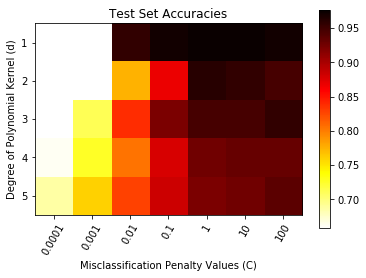

In [267]:
# load test accuracies into 2D numpy array
acc_img = np.array(test_acc).reshape(len(degrees), len(Cs))

# plot heatmap of accuracies
plt.imshow(acc_img, cmap=plt.cm.hot_r)
plt.colorbar()
plt.show()
plt.title('Test Set Accuracies')
plt.xticks(np.arange(len(Cs)), Cs, rotation=60)
plt.yticks(np.arange(len(degrees)), degrees)
plt.xlabel('Misclassification Penalty Values (C)')
plt.ylabel('Degree of Polynomial Kernel (d)');

Some general trends that we see with the different pairs of parameter values for the misclassification penalty hyperparameter (C) and polynomial degree (of the svc kernel) hyperparameter (d) using the heat map and printed training and test accuracies above: 

Accuracy of the model on the test set decreases as the degree of the polynomial kernel increases. On this particular data set, any polynomial kernel with a degree above 1 produces increasingly lower test set accuracies. This indicates that as the degree of the polynomial kernel increases, it is it overfitting the complexities or noise of the training data and, thus, not able to generalize and predict well with new data (test set). This goes along with the concept of the Bias-Variance tradeoff; as the degree of the polynomial kernel of the svc model increases (past 1), it is displaying high variance, which causes the algorithm to model or overfit the random noise in the training data rather than generalize the data well enough to perform (predict) well on new or other data. 

Another general trend we see is that lower misclassification penalty values (C) don't penalize the model enough and, thus, the model does not learn to classify at a high enough rate on the training data to do the same or generalize well enough on new or test data. In essence, these smaller misclassification penalty values creates a high bias; the model underfits the complexities of the training data or misses the relevant relationships between the features of the data and labels (or outputs) and, thus, it is not able to capture these crucial relationships in new or unseen data well enough.

Finally, we also see that too high of misclassification penalty values (C) can cause high variance or overfitting of the training data and, thus, the model is not able to generalize well on new data. 

The best pair of hyperparameters C (misclassification penalty) and d (degree of polynomial kernel) for the SVC model above are (C = .1, d = 1). The accuracy of the polynomial kernel svc model with these optimized hyperparameters is 97%, as seen above and just below in the following cell. 

In [300]:
final_svc_poly = svm.SVC(C=.1, degree=1, kernel='poly')
final_svc_poly.fit(X_train, y_train)
final_svc_poly.score(X_test, y_test)

0.97073170731707314

In medicine people often want to distinguish a false positive rate and a false negative rate instead of just an accuracy. This is because there are different consequences for the two categories of false results. False positives will result in unnecessary treatment while false negatives will result in lack of treatment. Here we will create a confusion matrix which gives the provides the two different error types (and correctly predicted results).

In [303]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, final_svc_poly.predict(X_test))
confusion_mat

array([[138,   4],
       [  2,  61]])

The confusion matrix above shows that the model generated 2 false negative and 4 false positive errors. 

# Radial Basis Function (RBF/Gaussian) kernel 

There is also a Radial Basis Function (RBF) kernel. This kernel has a hyperparameter called γ that determines the ”fineness” of the boundaries. A higher gamma will result in a more smooth boundary and a lower gamma will result in a more jagged boundary. Use cross validated grid search to find the best combination of γ and C on the breast cancer dataset.

We will create a similar function to the function above used to cross validate and optimize the hyperparamters of the RBF kernel SVC, C and gamma. 

In [397]:
def svc_param_selection_rbf(X, y, nfolds):
    #this is the slack penalty hyperparameter
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    #gamma parameter which inversely controls the standard deviation of our kernel's distributio
    gammas = [0.001, 0.01, 0.1, 1, 10, 100]
    #initialize the dictionary of parameters
    param_grid = {'C': Cs, 'gamma' : gammas}
    #initialize the search using input as nfold cross validation
    search = grid_search.GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    #fit the search object to our input training data
    search.fit(X, y)
    #output the best parameters
    search.best_params_
    return search.best_params_

Run the svc_param_selection_rbf function on the training data with 10 cross validation folds.

In [398]:
svc_param_selection_rbf(X_train, y_train, 10)

{'C': 1, 'gamma': 0.1}

Generate lists of test and training set accuracies using the different combinations of 
possible values for gamma and C hyperparamaters for RBF kernel svc.

In [399]:
# generate lists of test and training set accuracies using the different combinations of 
# possible values for gamma and C hyperparamaters for RBF kernel svc.
train_acc = []
test_acc = []

for g in gamma:
    for c in Cs:
        #print("C = ", c, ", degree = ", d)
        svc = svm.SVC(C=c, gamma=g, kernel='rbf')
        svc.fit(X_train, y_train)
        #print(svc.score(X_train, y_train))
        train_acc.append((svc.score(X_train, y_train)))
        #print((svc.score(X_test, y_test)))
        test_acc.append((svc.score(X_test, y_test)))
#print(max(test_acc))

The values from the list of test accuracies created above are reshaped into a 2-dimension numpy array and plotted by way of a heat map to indicate pairs of hyperparameter (C and gamma) values influence on test accuracies

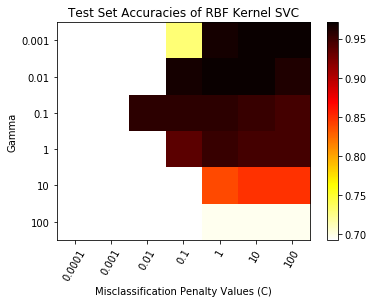

In [400]:
acc_img_rbf = np.array(test_acc).reshape(len(gamma), len(Cs))
plt.imshow(acc_img_rbf, cmap='hot_r')
plt.colorbar()
plt.show()
plt.title('Test Set Accuracies of RBF Kernel SVC')
plt.xticks(np.arange(len(Cs)), Cs, rotation=60)
plt.yticks(np.arange(len(gamma)), gamma)
plt.xlabel('Misclassification Penalty Values (C)')
plt.ylabel('Gamma');

Fit the gaussian (RBF) kernel support vector classifier, using the cross-validated hyperparameters C=1 and gamma=.01 to validation (test) data set.

In [392]:
svc_rbf = svm.SVC(C=1, gamma=.01, kernel='rbf')
svc_rbf.fit(X_train, y_train)
svc_rbf.score(X_test, y_test)

0.97073170731707314

Similar to the polynomial kernel support vector classifier above, we receive a 97% accuracy using the optimized hyperparameters C=1 and gamma=.01 on our rbf kernel svc. 

Below we will create the confusion matrix generated by the rbf kernel svc model above.

In [403]:
confusion_mat = confusion_matrix(y_test, svc_rbf.predict(X_test))
confusion_mat

array([[138,   4],
       [  2,  61]])

Again, similar to our polynomial kernel svc model above, our rbf kernel svc model generated four false positive errors and two false negative errors.

# Conclusion

As you have seen SVMs easily get above 90% on this dataset. With just a bit of hyperparameter tuning we can push this number up to a remarkable 97%. Moreover, SVMs are a very simple algorithm and have taken no more than a few seconds to train on the computer. The potential to create models so easily that are this accurate on a task as complicated as breast cancer classification is perhaps one of the reasons that machine learning has become such a hot topic as of late.